In [1]:
import sys
sys.path.append('..')
from NCA.trainer.NCA_trainer import NCA_Trainer
from Common.utils import load_emoji_sequence
from Common.eddie_indexer import index_to_data_nca_type
from NCA.trainer.data_augmenter_nca import DataAugmenter
from NCA.model.NCA_model import NCA
from einops import rearrange
import time
import jax
import jax.numpy as np
import optax
import matplotlib.pyplot as plt


2024-07-24 11:19:51.783983: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 11:19:51.784011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 11:19:51.785075: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 11:19:52.934494: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Define all the variables

In [2]:
CHANNELS = 16           # How many channels to use in the model
TRAINING_STEPS = 100   # How many steps to train for
DOWNSAMPLE = 4          # How much to downsample the image by
NCA_STEPS = 32          # How many NCA steps between each image in the data sequence

## Create a Neural Cellular Automata model
 - There are a few important parameters:
    - `KERNEL_STR` defines what sort of spatial kernels we use
    - `ACTIVATION` accepts any scalar function, acting as the neural network nonlinearity
    - `PADDING` must be "CIRCULAR", "REFLECT" , "REPLICATE" or "ZEROS" - this controls how to handle the borders of the image
    - `FIRE_RATE` must be between 0 and 1 - it is the probability of updating each pixel at each step

In [3]:
model = NCA(N_CHANNELS=CHANNELS,
            KERNEL_STR=["ID","GRAD","LAP"],
            ACTIVATION=jax.nn.relu,
            PADDING="CIRCULAR",
            FIRE_RATE=0.5)


## Load Data
 - Here we load an individual image from `demo_data/` , and create an initial condition of one seed pixel
 - `load_emoji_sequence` takes a list of strings like `["file_1","file_2",...]` and returns:
   
    an array of shape `[Batch, Timestep, Channels, Width, Height]`, where:
      - `Batch` is currently 1 - this matters more later if we want to train to multiple images at the same time
      - `Timestep` is the length of the input list
      - `Channels` is typically 3 or 4 for colour channels
      - `Width` and `Height` are for the image size

 -  We also use the `DataAugmenter` class, defined in `NCA.trainer.data_augmenter_nca.py`
    - This has a few useful functions for modifying the data during training to produce better results
    - This also adds extra hidden channels to an image
    - By creating subclasses of `DataAugmenter` we can define what behaviour to apply to data during training
         - In this example we just pad the data with extra zeros around the boundary

(1, 2, 4, 30, 30)
(Batch, Time, Channels, Width, Height): (1, 3, 4, 30, 30)


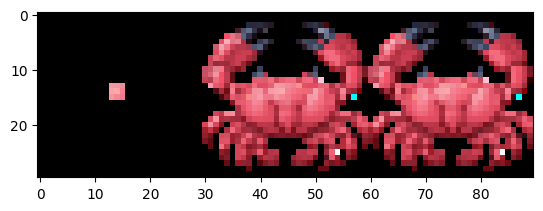

In [4]:
data = load_emoji_sequence(["crab.png","crab.png"],impath_emojis="demo_data/",downsample=DOWNSAMPLE)


# For the initial condition, take a small cropped square from the middle of the target image
initial_condition = np.array(data[:,:1])
print(data.shape)
W = initial_condition.shape[-2]
H = initial_condition.shape[-1]
initial_condition = initial_condition.at[0,0,:,:W//2-2].set(0)
initial_condition = initial_condition.at[0,0,:,W//2+1:].set(0)
initial_condition = initial_condition.at[0,0,:,:,:H//2-2].set(0)
initial_condition = initial_condition.at[0,0,:,:,H//2+1:].set(0)


data = np.concatenate([initial_condition,data],axis=1) # Join initial condition and data along the time axis
print("(Batch, Time, Channels, Width, Height): "+str(data.shape))
plt.imshow(rearrange(data,"() T C W H -> W (T H) C" )[...,:3])
plt.show()


class data_augmenter_subclass(DataAugmenter):
    #Redefine how data is pre-processed before training
    def data_init(self,SHARDING=None):
        data = self.return_saved_data()
        data = self.duplicate_batches(data, 1)
        data = self.pad(data, 10) 		
        self.save_data(data)
        return None
    

## Define the trainer object
- The `NCA_Trainer` takes as input the `model`, the `data` and a reference to the `DataAugmenter` class (or a custom subclass)
    - It also takes a `model_filename` for saving the output
- `NCA_Trainer` also logs a lot of training statistics using tensorboard, instructions to read that are below

In [5]:
trainer = NCA_Trainer(NCA_model=model,
                      data = data,
                      DATA_AUGMENTER=data_augmenter_subclass,
                      model_filename="test_grow_crab",
                      directory="demo")

Batches = 1
Logging training to: logs/test_grow_crab/train
Saving model to: demotest_grow_crab


## Training
- Run the following code cell first, then follow these instructions to view how the training is progressing

### Evaluating training:
- In the terminal, run the following command:

`tensorboard --samples_per_plugin images=200 --logdir logs/test_grow_crab/train/`

- Where `test_grow_crab` is the model filename we supplied when defining the `NCA_Trainer`

- Then, open your browser and go to: `http://localhost:6006/`

In [6]:
schedule = optax.exponential_decay(1e-3, transition_steps=TRAINING_STEPS, decay_rate=0.99)
optimiser = optax.chain(optax.scale_by_param_block_norm(),
                        optax.nadam(schedule))


trainer.train(t=NCA_STEPS,iters=TRAINING_STEPS,LOOP_AUTODIFF="lax",optimiser=optimiser)

 66%|██████▌   | 66/100 [01:47<00:49,  1.46s/it]

--- Model saved at 65 epochs with loss 0.098029815 ---


 68%|██████▊   | 68/100 [01:50<00:45,  1.43s/it]

--- Model saved at 67 epochs with loss 0.09769666 ---


 80%|████████  | 80/100 [02:07<00:28,  1.40s/it]

--- Model saved at 79 epochs with loss 0.097275466 ---


 81%|████████  | 81/100 [02:10<00:33,  1.78s/it]

--- Model saved at 80 epochs with loss 0.09620975 ---


 83%|████████▎ | 83/100 [02:13<00:26,  1.59s/it]

--- Model saved at 82 epochs with loss 0.095573954 ---


 88%|████████▊ | 88/100 [02:20<00:17,  1.42s/it]

--- Model saved at 87 epochs with loss 0.0953664 ---


 89%|████████▉ | 89/100 [02:21<00:15,  1.41s/it]

--- Model saved at 88 epochs with loss 0.09393556 ---


 97%|█████████▋| 97/100 [02:33<00:04,  1.42s/it]

--- Model saved at 96 epochs with loss 0.09326409 ---


 99%|█████████▉| 99/100 [02:36<00:01,  1.45s/it]

--- Model saved at 98 epochs with loss 0.09280935 ---


100%|██████████| 100/100 [02:37<00:00,  1.58s/it]


Training completed successfully
Running final trained model for 128 steps


100%|██████████| 1/1 [00:02<00:00,  2.60s/it]


## Loading a trained NCA
- Here we can access the trained model as `trainer.NCA_model`
- We can also load NCA model weights with `model.load("demo/models/test_grow_crab.eqx")`, replacing the filename string as needed
    - Note that we have to define the NCA object first, with the correct number of channels and kernels

In [18]:
model = trainer.NCA_model

In [ ]:
model = NCA(N_CHANNELS=CHANNELS,
            KERNEL_STR=["ID","GRAD","LAP"],
            ACTIVATION=jax.nn.relu,
            PADDING="CIRCULAR",
            FIRE_RATE=0.5)

model = model.load("demo/models/test_grow_crab.eqx")

## Testing trained NCA models
- We can test it on the initial condition, given from `trainer.DATA_AUGMENTER.return_saved_data()[0][0]`

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


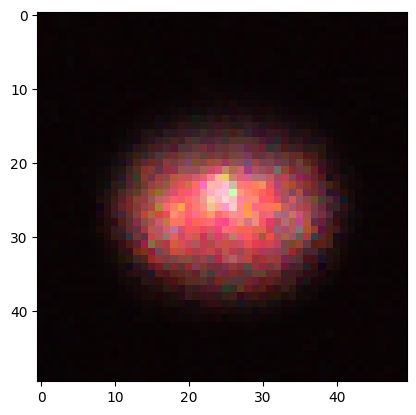

In [19]:
x0 = trainer.DATA_AUGMENTER.return_saved_data()[0][0]

#print(x0.shape)
#x0 = x0.at[:,:x0.shape[1]//2-1].set(0)

trajectory = model.run(NCA_STEPS,x0)

trajectory = rearrange(trajectory,"T C W H-> T W H C")
plt.imshow(trajectory[-1,...,:3])
plt.show()

### Running a trained NCA on a damaged initial condition
- We can take the initial 3*3 starting seed and remove part of it, or otherwise damage it, and then see what the NCA does



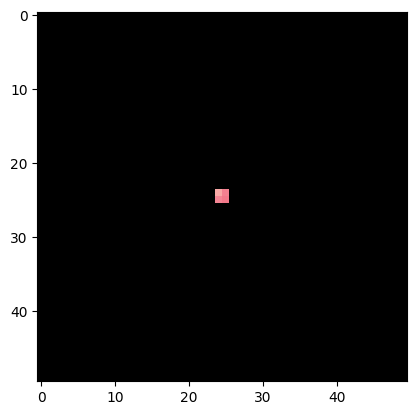

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


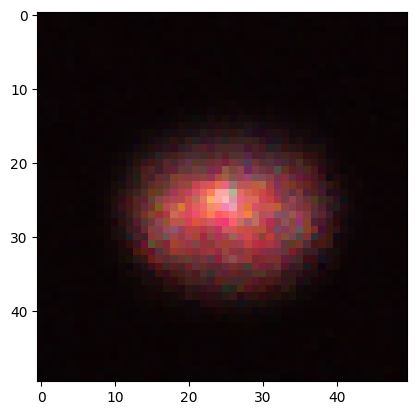

In [28]:
model = trainer.NCA_model
x0 = trainer.DATA_AUGMENTER.return_saved_data()[0][0]

#print(x0.shape)
x0 = x0.at[:,:x0.shape[1]//2-1].set(0)
x0 = x0.at[:,:,:x0.shape[2]//2-1].set(0)
plt.imshow(rearrange(x0,"C W H -> W H C" )[...,:3])
plt.show()
trajectory = model.run(NCA_STEPS,x0)

trajectory = rearrange(trajectory,"T C W H-> T W H C")
plt.imshow(trajectory[-1,...,:3])
plt.show()

### Regenerating with a trained NCA
- By starting at half of the target image, can we regrow the other half?

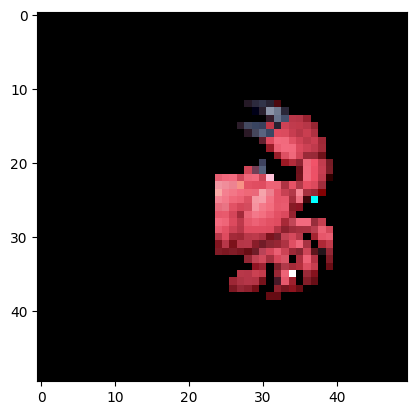

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


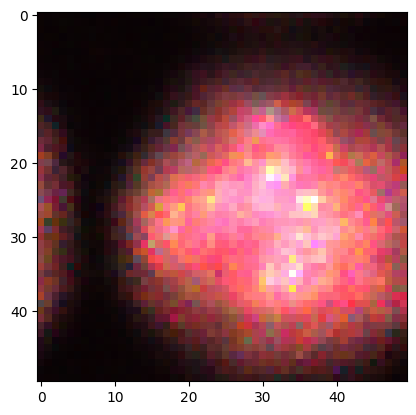

In [32]:
model = trainer.NCA_model
x0 = trainer.DATA_AUGMENTER.return_saved_data()[0][1]

#print(x0.shape)
#x0 = x0.at[:,:x0.shape[1]//2-1].set(0)
x0 = x0.at[:,:,:x0.shape[2]//2-1].set(0)
plt.imshow(rearrange(x0,"C W H -> W H C" )[...,:3])
plt.show()
trajectory = model.run(NCA_STEPS,x0)

trajectory = rearrange(trajectory,"T C W H-> T W H C")
plt.imshow(trajectory[-1,...,:3])
plt.show()